In [416]:
import warnings
warnings.filterwarnings('ignore')

In [417]:
import numpy as np
import pandas as pd 
import tensorflow as tf
from bs4 import BeautifulSoup
import re
import matplotlib.pyplot as plt
import nltk

In [418]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

### Load Dataset

In [419]:
data=pd.read_csv('datasets/tweets.csv')

### Check for null values

In [420]:
data.isnull().sum()

tweets    0
labels    0
dtype: int64

In [421]:
#get stopword list
sw_list=stopwords.words('english')

### Since it might affect final outcome, a few words are removed from stopwords list

In [422]:
print(f"Not----->{'not' in sw_list}\nNo------>{'no' in sw_list}\nAgainst->{'against' in sw_list}")

Not----->True
No------>True
Against->True


In [423]:
sw_list.remove('not')
sw_list.remove('no')
sw_list.remove('against')

In [424]:
print(f"Not----->{'not' in sw_list}\nNo------>{'no' in sw_list}\nAgainst->{'against' in sw_list}")

Not----->False
No------>False
Against->False


In [425]:
#Initialize lemmatizer
lemmatizer=WordNetLemmatizer()

### Function to clean tweets

In [426]:
def clean_tweets(tweet):
    #remove RT(retweet tag)
    tweet=re.sub(r"RT @","@",tweet)
    #remove pings
    tweet = re.sub(r"@[A-Za-z0-9]+", ' ', tweet)
    #remove URLs
    tweet = re.sub(r"https?://[A-Za-z0-9./]+", ' ', tweet)
    #remove special characters
    tweet = re.sub(r"[^a-zA-Z]", ' ', tweet)
    #convert to lower case
    tweet=tweet.lower()
    #remove extra white spaces
    tweet = re.sub(r" +",' ', tweet)
    #tokenize tweet for removing stopwords and lemmatization
    tokenized_tweet=word_tokenize(tweet)
    #lemmatization of tweet and removing stopwords
    lemmatized_tweet=[lemmatizer.lemmatize(word) for 
                      word in tokenized_tweet if not word in sw_list]
    lemmatized_tweet=' '.join(lemmatized_tweet)
    #remove extra white spaces
    tweet = re.sub(r" +", ' ', tweet)
    return lemmatized_tweet.strip()


In [427]:
data['tweets']=[clean_tweets(tweet) for tweet in data['tweets']]

### Checking and Discarding tweets left empty after cleaning (tweets that contained only retweets, pings and URLs)

In [428]:
data[data['tweets']=='']

,tweets,labels
446,,0
905,,0
1067,,0
1082,,0
1093,,0
1101,,0
1290,,0


In [429]:
len(data)

1364

In [430]:
data.eq('').sum()

tweets    7
labels    0
dtype: int64

In [431]:
data.replace("",np.nan,inplace=True)
data.dropna(subset=['tweets'],inplace=True)
data.eq('').sum()

tweets    0
labels    0
dtype: int64

In [432]:
len(data)

1357

In [433]:
from sklearn.model_selection import train_test_split
X=data['tweets']
y=data['labels']
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=7)

In [434]:
lengths=pd.DataFrame(len(tweet.split(' ')) for tweet in X_train)

In [435]:
test_length=pd.DataFrame(len(tweet.split(' ')) for tweet in X_test)

In [436]:
max_len=max(len(tweet.split(' ')) for tweet in X_train)

### Get word count of tweet with most words

In [437]:
max_len

24

## Modeled using : max_features=max_len

### TF-IDF Vectorization

In [438]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [439]:
tfidf_vect=TfidfVectorizer(max_len)
X_train_tfidf=tfidf_vect.fit_transform(X_train).toarray()
X_test_tfidf=tfidf_vect.transform(X_test).toarray()
X_train_tfidf=pd.DataFrame(X_train_tfidf)
X_test_tfidf=pd.DataFrame(X_test_tfidf)

### Combined dataframe of training data

In [440]:
train_data=pd.concat((X_train,y_train),axis=1,ignore_index=True)
train_data.columns=['tweets','labels']
train_data.reset_index(inplace=True,drop=True)
train_data=pd.concat((train_data,X_train_tfidf),axis=1)
train_data

,tweets,labels,0,1,2,3,4,5,6,7,...,2611,2612,2613,2614,2615,2616,2617,2618,2619,2620
0,obama admin cry tax increase applaud china low...,0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,barack obama longboard package core truck mm b...,0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,edshow whenever obama tell truth gop boo hoo h...,0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,many foreign leader obama promised post electi...,0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,obama signaled u would accept iranian civilian...,1,0.0,0.0,0.0,0.0,0.0,0.000000,0.259903,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1080,mean saving scotus tell world obama wrong aca ...,0,0.0,0.0,0.0,0.0,0.0,0.334194,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1081,obama sharpens kansa vision,0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1082,genius man sing else really obama,1,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1083,mitt romney obama spent much time harvard also...,0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Combined dataframe of test data

In [441]:
test_data=pd.concat((X_test,y_test),axis=1,ignore_index=True)
test_data.columns=['tweets','labels']
test_data.reset_index(inplace=True,drop=True)
test_data=pd.concat((test_data,X_test_tfidf),axis=1)
test_data

,tweets,labels,0,1,2,3,4,5,6,7,...,2611,2612,2613,2614,2615,2616,2617,2618,2619,2620
0,harry style describe michelle obama como una m...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,amp si khady president obama got elected nyrel...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,obama black american really need time whitey f...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,whatsromneyhiding throw baseball like man not ...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,realclearpolitics obama organizational advanta...,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
267,romney attack obama barnstorming pennsylvania,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
268,obama thug bully not sure call rush limbaugh bill,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
269,michelle barack obama become like celebrity ta...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
270,whatsromneyhiding nothing compared mt proof ob...,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [442]:
y_train.unique()

array([0, 1, 2], dtype=int64)

In [443]:
from tensorflow.keras.utils import to_categorical
y_train=to_categorical(y_train,3)

In [444]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout

In [445]:
tf.keras.backend.set_floatx('float64')

In [446]:
model=Sequential()
model.add(Dense(activation='relu',units=64))
model.add(Dropout(0.2))
model.add(Dense(activation='relu',units=32))
model.add(Dense(activation='softmax',units=3))
model.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['accuracy'])

In [447]:
history=model.fit(x=X_train_tfidf,y=y_train,epochs=20)

Epoch 1/20
34/34 [==============================] - 0s 3ms/step - loss: 1.0169 - accuracy: 0.6498
Epoch 2/20
34/34 [==============================] - 0s 3ms/step - loss: 0.7807 - accuracy: 0.7143
Epoch 3/20
34/34 [==============================] - 0s 3ms/step - loss: 0.5840 - accuracy: 0.7724
Epoch 4/20
34/34 [==============================] - 0s 3ms/step - loss: 0.4415 - accuracy: 0.8267
Epoch 5/20
34/34 [==============================] - 0s 3ms/step - loss: 0.3387 - accuracy: 0.8793
Epoch 6/20
34/34 [==============================] - 0s 3ms/step - loss: 0.2652 - accuracy: 0.9014
Epoch 7/20
34/34 [==============================] - 0s 3ms/step - loss: 0.2023 - accuracy: 0.9290
Epoch 8/20
34/34 [==============================] - 0s 3ms/step - loss: 0.1504 - accuracy: 0.9484
Epoch 9/20
34/34 [==============================] - 0s 3ms/step - loss: 0.1193 - accuracy: 0.9622
Epoch 10/20
34/34 [==============================] - 0s 3ms/step - loss: 0.0856 - accuracy: 0.9816
Epoch 11/20
34/34 [

In [448]:
y_test=to_categorical(y_test,3)
y_predictions=(model.predict(X_test_tfidf) > 0.5).astype("int32")

In [449]:
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score

In [450]:
print(classification_report(y_test,y_predictions))

              precision    recall  f1-score   support

           0       0.87      0.95      0.91       182
           1       0.81      0.71      0.75        78
           2       0.86      0.50      0.63        12

   micro avg       0.86      0.86      0.86       272
   macro avg       0.85      0.72      0.76       272
weighted avg       0.85      0.86      0.85       272
 samples avg       0.86      0.86      0.86       272



In [451]:
print(accuracy_score(y_test,y_predictions))

0.8566176470588235


In [452]:
confusion_matrix(y_test.argmax(axis=1),y_predictions.argmax(axis=1))

array([[172,  10,   0],
       [ 22,  55,   1],
       [  3,   3,   6]], dtype=int64)

In [453]:
losses=pd.DataFrame(history.history)

<AxesSubplot:>

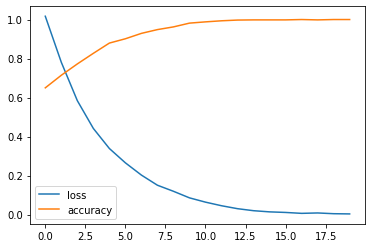

In [454]:
losses.plot()

## Modeled without: max_features=max_len

In [455]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vect=TfidfVectorizer()
X_train_tfidf=tfidf_vect.fit_transform(X_train).toarray()
X_test_tfidf=tfidf_vect.transform(X_test).toarray()
X_train_tfidf=pd.DataFrame(X_train_tfidf)
X_test_tfidf=pd.DataFrame(X_test_tfidf)

In [456]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout

In [457]:
model_2=Sequential()
model_2.add(Dense(activation='relu',units=64))
model_2.add(Dropout(0.2))
model_2.add(Dense(activation='relu',units=32))
model_2.add(Dense(activation='softmax',units=3))
model_2.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['accuracy'])

In [458]:
history_2=model_2.fit(x=X_train_tfidf,y=y_train,epochs=20)

Epoch 1/20
34/34 [==============================] - 0s 3ms/step - loss: 0.8787 - accuracy: 0.6774
Epoch 2/20
34/34 [==============================] - 0s 3ms/step - loss: 0.6623 - accuracy: 0.6876
Epoch 3/20
34/34 [==============================] - 0s 3ms/step - loss: 0.5338 - accuracy: 0.7668
Epoch 4/20
34/34 [==============================] - 0s 3ms/step - loss: 0.4141 - accuracy: 0.8313
Epoch 5/20
34/34 [==============================] - 0s 3ms/step - loss: 0.3170 - accuracy: 0.8820
Epoch 6/20
34/34 [==============================] - 0s 3ms/step - loss: 0.2325 - accuracy: 0.9180
Epoch 7/20
34/34 [==============================] - 0s 3ms/step - loss: 0.1762 - accuracy: 0.9382
Epoch 8/20
34/34 [==============================] - 0s 3ms/step - loss: 0.1334 - accuracy: 0.9493
Epoch 9/20
34/34 [==============================] - 0s 3ms/step - loss: 0.1026 - accuracy: 0.9668
Epoch 10/20
34/34 [==============================] - 0s 3ms/step - loss: 0.0698 - accuracy: 0.9853
Epoch 11/20
34/34 [

In [459]:
y_predictions=(model_2.predict(X_test_tfidf) > 0.5).astype("int32")

In [460]:
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
print(classification_report(y_test,y_predictions))

              precision    recall  f1-score   support

           0       0.87      0.95      0.91       182
           1       0.82      0.72      0.77        78
           2       1.00      0.50      0.67        12

   micro avg       0.86      0.86      0.86       272
   macro avg       0.90      0.72      0.78       272
weighted avg       0.86      0.86      0.86       272
 samples avg       0.86      0.86      0.86       272



In [463]:
print(accuracy_score(y_test,y_predictions))

0.8602941176470589


In [461]:
confusion_matrix(y_test.argmax(axis=1),y_predictions.argmax(axis=1))

array([[173,   9,   0],
       [ 22,  56,   0],
       [  3,   3,   6]], dtype=int64)

<AxesSubplot:>

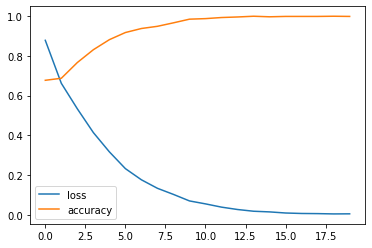

In [462]:
losses=pd.DataFrame(history_2.history)
losses.plot()